## Gate Cutting to Reduce Circuit Width

In this tutorial we will simulate expectation values of a four-qubit circuit using only two-qubit experiments by cutting gates in the circuit.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **decompose** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments on the backend(s)
- **reconstruct** the simulated expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting.cutting import (
    partition_problem,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to cut

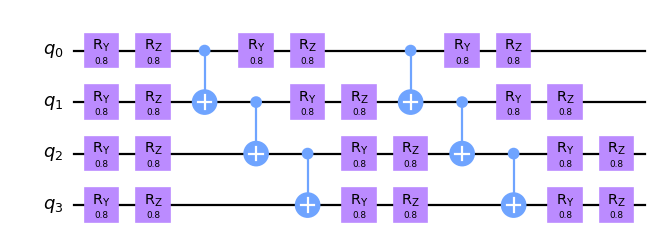

In [2]:
circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)

circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.3.0.

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Separate the circuit and observables according to a specified qubit partitioning

Each label in `partition_labels` corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [4]:
subcircuits, bases, subobservables = partition_problem(
    circuit=circuit, partition_labels="AABB", observables=observables
)

`partition_problem` returns:

- `Dict` mapping partition labels to subcircuits
- `Dict` mapping partition labels to subobservables
- The ``QPDBasis`` instances from each gate decomposition

### Visualize the decomposed problem

In [5]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

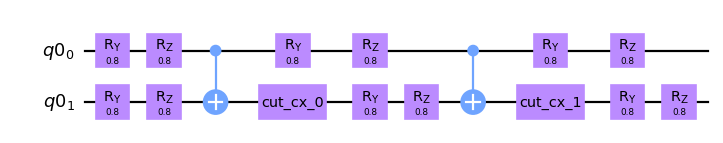

In [6]:
subcircuits["A"].draw("mpl", scale=0.8)

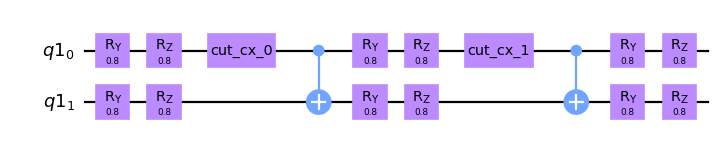

In [7]:
subcircuits["B"].draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

The sampling overhead is an indication of the number of additional samples one would need to reconstruct the expectation value of the full-sized circuit using cutting, and it scales exponentially with the number of cuts.

The optimal sampling overhead for cutting a CNOT gate is $9$, so the number of extra samples needed for cutting many CNOT gates scales with complexity $O$($9^n$), where $n$ is the number of cuts. Here we cut two CNOT gates, resulting in a sampling overhead of $9^2$.

In [8]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


### Generate and run the cutting experiments

`execute_experiments` accepts `circuits`/`subobservables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends.

Much of the circuit cutting literature describes a process where we sample from the distribution, take a single shot, sample from the distribution again and repeat; however, this is not feasible in practice. The number of shots needed grows exponentially with the number of cuts, and single shot experiments via Qiskit Runtime quickly become untenable. Instead, we take an equivalent number of shots for each sampled subexperiment, and send them to the backend(s) in batches. We just need to ensure the number of shots we take is appropriate for the heaviest-weighted samples, and thus, appropriate for all samples.

The number of samples taken from the distribution is controlled by `num_samples`. If the smallest sample probability in the joint quasi-probability distribution is above 1 / `num_samples`, exact weights will be used.  Otherwise, the weights will be sampled, resulting in at most `num_samples` unique samples.  In the future, this function will be changed to return a mixture of exact and sampled weights, so that the largest weights will be calculated exactly, while weights in the tail of the distribution will be sampled.

In [9]:
# Keep in mind, Terra Sampler does not support mid-circuit measurements at all,
# and Aer Sampler does not support mid-circuit measurements when shots==None.
samplers = {
    "A": Sampler(run_options={"shots": 2**12}),
    "B": Sampler(run_options={"shots": 2**12}),
}

quasi_dists, coefficients = execute_experiments(
    circuits=subcircuits,
    subobservables=subobservables,
    num_samples=1500,
    samplers=samplers,
)

`execute_experiments` returns:

- A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment
- The coefficients for each subexperiment

### Reconstruct the simulated expectation values
`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape (`num_unique_samples`, `num_partitions`, `num_commuting_observ_groups`), and `coefficients` is a list with length equal to the number of unique samples. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s), as output from `decompose_problem` above.

In [10]:
simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    subobservables,
)

The output of `reconstruct_expectation_values` is a list of simulated expectation values -- one for each observable.

### Compare the simulated expectation values with the exact expectation values from the original circuit

In [11]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Simulated expectation values: {[np.round(simulated_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(simulated_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((simulated_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [0.18668991, 0.17847931, 0.34113455, 0.42456776, 0.07754993, 0.70771587]
Exact expectation values: [0.17153613, 0.1815846, 0.30958691, 0.44036036, 0.08173037, 0.70623815]
Errors in estimation: [0.01515378, -0.00310529, 0.03154763, -0.0157926, -0.00418043, 0.00147771]
Relative errors in estimation: [0.08834162, -0.01710105, 0.10190235, -0.03586291, -0.05114909, 0.00209237]
